In [985]:
#import sys
#!{sys.executable} -m pip install statsmodels

In [986]:
import function
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
df = pd.read_csv("beer_profile_and_ratings.csv" )
#pd.set_option("display.max_rows", None, "display.max_columns", None)
print(len(df))
print(len(df["Style"].value_counts()))
print(len(df["Brewery"].value_counts()))
print(df["Fruits"][3])
print(df.columns)
summary = df['Fruits'].describe()
print(summary)
import plotly.graph_objs as go
from ipywidgets import *
from importlib import reload
#import statsmodels.api as sm
function = reload(function)
df = df.sort_values(by='review_aroma')


3197
111
934
49
Index(['Name', 'Style', 'Brewery', 'Beer Name (Full)', 'Description', 'ABV',
       'Min IBU', 'Max IBU', 'Astringency', 'Body', 'Alcohol', 'Bitter',
       'Sweet', 'Sour', 'Salty', 'Fruits', 'Hoppy', 'Spices', 'Malty',
       'review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'review_overall', 'number_of_reviews'],
      dtype='object')
count    3197.000000
mean       38.529559
std        32.296646
min         0.000000
25%        12.000000
50%        29.000000
75%        60.000000
max       175.000000
Name: Fruits, dtype: float64


## task 1 : Separate arbitrarily a small subset of observations from the dataset

In [987]:
subset = df.sample(frac=0.1)

## task 2: Formulating an objective

the objective with this dataset is to be able to predict the "review_overall" of a element 

we could also try to determine what factors have the most impact on a score and give feedback to improve a beer based on it's attributes :

Here is an outline of the process:

    -Collect a labeled dataset, where each entry is associated with a score and its attributes.
    -Preprocess the data, including splitting it into training and testing sets.
    -Train a model on the training set, using a supervised learning algorithm such as linear regression, decision tree, or random forest.
    -Test the model on the testing set and evaluate its performance.
    -Use the trained model to predict the score for a new entry with the attributes you want to change.
    -Modify the attributes of the new entry and re-predict the score using the trained model.
    -Compare the scores obtained before and after modifying the attributes to determine which attribute changes lead to an improvement in the score.

It's worth noting that this process assumes that the relationship between the attributes and the score is linear or can be approximated by a linear model. If this is not the case, you may need to use a more complex model or consider other approaches to identify the attribute changes that lead to an improvement in the score.

## task 3: Descriptive analysis 

| - informative variables: | - Qualitative variables:   | - Quantitative variable: | - Scores: |
|------|------|------|------|
|   1 Name |1 Style|1 ABV|1 review_aroma
|2 Full Name |2 brewery|2 Min IBU|2 review_appearance
|3 description  | | 3 Max IBU|3 review_palate
| | |4 Astringency|4 review_taste
| | |5 Body|///////////////////////////////////|
| | |6 Alcohol|5 review_overall
| | |7 Bitter|
| | |8 Sweet|
| | |9 Sour|
| | |10 Salty|
| | |11 Fruits|
| | |12 Hoppy|
| | |13 Spices|
| | |14 Malty| 


The informative variables don't give a lot of information about the score that are not already presents in the other variables. Therefore they wont be used 

The qualitative variables will be one-hot encoded to be treated as Quantitative variables 

The Quantitative variables will be used as his 

the scores will be used as target for the model 

| name              |      mean |        std |   skewness |   kurtosis |
|:------------------|----------:|-----------:|-----------:|-----------:|
| Style             |  55.5705  |  32.3737   | -0.0196824 |  -1.18762  |
| Brewery           | 296.225   | 169.184    | -0.178968  |  -1.2789   |
| ABV               |   6.52669 |   2.547    |  3.67993   |  55.2444   |
| Min IBU           |  21.1805  |  13.2422   |  1.09326   |   1.32465  |
| Max IBU           |  38.9869  |  21.3553   |  0.99054   |   0.977638 |
| Astringency       |  16.5158  |  10.4107   |  1.31567   |   2.7722   |
| Body              |  46.1295  |  25.9478   |  1.14028   |   1.61526  |
| Alcohol           |  17.056   |  17.3313   |  2.23306   |   6.28596  |
| Bitter            |  36.3644  |  25.7912   |  1.00606   |   0.938633 |
| Sweet             |  58.2709  |  34.2813   |  0.905323  |   1.31787  |
| Sour              |  33.1454  |  35.7802   |  2.52257   |   7.85566  |
| Salty             |   1.0172  |   2.13265  |  7.53925   | 115.175    |
| Fruits            |  38.5296  |  32.2966   |  0.944666  |   0.220681 |
| Hoppy             |  40.9246  |  30.4036   |  1.10125   |   0.909249 |
| Spices            |  18.3456  |  23.7566   |  2.89396   |  10.4379   |
| Malty             |  75.3309  |  39.9093   |  0.382408  |  -0.195185 |
| review_aroma      |   3.63879 |   0.503209 | -1.09663   |   1.739    |
| review_appearance |   3.75439 |   0.403416 | -1.41173   |   2.90485  |
| review_palate     |   3.66043 |   0.449937 | -1.19533   |   2.19325  |
| review_taste      |   3.7025  |   0.510361 | -1.15676   |   1.9346   |
| review_overall    |   3.74752 |   0.444288 | -1.31737   |   2.72505  |
| number_of_reviews | 233.285   | 361.812    |  3.02845   |  11.8498   |

In [988]:

def describe_columns(dataset):
    # create an empty dataframe to store the results
    results = pd.DataFrame(columns=["name",'mean', 'std', 'skewness', 'kurtosis'])
    
    # iterate over each column in the dataset
    for col in dataset.columns:

        if (dataset[col].dtypes == float or dataset[col].dtypes == int):
        # calculate the mean, standard deviation, skewness, and kurtosis
            
            mean = dataset[col].mean()
            std = dataset[col].std()
            skewness = skew(dataset[col])
            kurt = kurtosis(dataset[col])
            results.loc[col] = [ col, mean, std, skewness, kurt]

       
        
    return results

def set_to_nan(df , name):
    counts = df[name].value_counts()
    to_replace = counts[counts == 1].index

    # Replace these elements with NaN
    df[name].replace(to_replace, np.nan, inplace=True)


In [989]:
set_to_nan(df, "Brewery")
set_to_nan(df, "Style")
encoder = LabelEncoder()
df['Style'] = encoder.fit_transform(df['Style'])
df['Brewery'] = encoder.fit_transform(df['Brewery'])
table = describe_columns(df)
markdown_table = table.to_markdown(index=False)
print(markdown_table)


| name              |      mean |        std |   skewness |   kurtosis |
|:------------------|----------:|-----------:|-----------:|-----------:|
| Style             |  55.5705  |  32.3737   | -0.0196824 |  -1.18762  |
| Brewery           | 296.225   | 169.184    | -0.178968  |  -1.2789   |
| ABV               |   6.52669 |   2.547    |  3.67993   |  55.2444   |
| Min IBU           |  21.1805  |  13.2422   |  1.09326   |   1.32465  |
| Max IBU           |  38.9869  |  21.3553   |  0.99054   |   0.977638 |
| Astringency       |  16.5158  |  10.4107   |  1.31567   |   2.7722   |
| Body              |  46.1295  |  25.9478   |  1.14028   |   1.61526  |
| Alcohol           |  17.056   |  17.3313   |  2.23306   |   6.28596  |
| Bitter            |  36.3644  |  25.7912   |  1.00606   |   0.938633 |
| Sweet             |  58.2709  |  34.2813   |  0.905323  |   1.31787  |
| Sour              |  33.1454  |  35.7802   |  2.52257   |   7.85566  |
| Salty             |   1.0172  |   2.13265  |  7.5

In [990]:
columns = df.columns
columns_to_keep = [col for col in columns if col not in ["Name", "Beer Name (Full)","Description"]]
dfcorr = df[columns_to_keep]

corr = dfcorr.corr()

# Use the seaborn library to create a heat map of the correlations
fig = px.imshow(corr, title="Correlation Heat Map")
fig.show()

In [991]:

function.InteractiveBoxPlot(dfcorr)



    'data': [{'type': 'box',
              'uid': 'acd70e30-7698-4fb3-8a89-6af11…

## task 4.1: nonlinearity

In [992]:
function.InteractiveScatter(dfcorr , df)

    'data': [{'customdata': array(['Evil Eye', 'Asahi Honnama Aqua Blue', 'Coron…

In [993]:
print(dfcorr["review_overall"])

1407    1.471154
758     1.857143
1349    1.957602
760     2.071429
1346    2.159656
          ...   
1653    4.750000
2468    4.500000
18      4.500000
1670    4.500000
1669    4.500000
Name: review_overall, Length: 3197, dtype: float64


In [994]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


In [995]:
function.InteractiveScatter(dfcorr , df)

    'data': [{'customdata': array(['Evil Eye', 'Asahi Honnama Aqua Blue', 'Coron…

In [996]:
from statsmodels.multivariate.pca import PCA

for col in dfcorr:
    dfcorr[col] = (dfcorr[col] - dfcorr[col].mean()) / dfcorr[col].std()

from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.0)
X_train, X_test, y_train, y_test = train_test_split(dfcorr.drop(['review_aroma', 'review_appearance', 'review_palate', 'review_taste', 'review_overall'], axis =1), dfcorr["review_overall"], test_size=0.2)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
res2 = clf.fit(X_train, y_train)

mod = sm.OLS(y_train,X_train)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         review_overall   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     63.58
Date:                Thu, 05 Jan 2023   Prob (F-statistic):          4.81e-181
Time:                        15:45:31   Log-Likelihood:                -3156.4
No. Observations:                2557   AIC:                             6349.
Df Residuals:                    2539   BIC:                             6454.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0033      0.01

/var/folders/gj/3zjx0x1d3x3bj6bfrlgym5fw0000gs/T/ipykernel_7365/3572438837.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [997]:
clean_df = dfcorr.copy()

#for col in clean_df.columns:
    # Calculate the Z-score
#    z_score = (clean_df[col] - clean_df[col].mean()) / clean_df[col].std()
    
    # Remove outliers
#    clean_df = clean_df[(z_score < 3) & (z_score > -3)]

#print(list(clean_df.columns))

#md = MahalanobisDist(np.array(clean_df))
#print(md)
X=np.array(X_train)
X_transpose_X = np.dot(X.T, X)

# Calculate the inverse of X'X
X_transpose_X_inv = np.linalg.inv(X_transpose_X)

# Calculate the projection matrix H
H = np.dot(X, X_transpose_X_inv)
H = np.dot(H , X.T)

# Calculate the leverage for each point
leverage = np.diagonal(H)

threshold = 2 * 17 / len(X_train) 

print(leverage)
print(threshold)
print(len(X_train) )
X_outliers=[]
for i in range (len(leverage)):
    if leverage[i] > threshold:
        X_outliers.append(i)
        
print(X_outliers)
print(len(X_outliers))

[0.00280463 0.01091126 0.00588146 ... 0.00620867 0.00614579 0.00225401]
0.01329683222526398
2557
[26, 40, 43, 57, 78, 82, 113, 126, 136, 149, 176, 184, 204, 208, 224, 225, 259, 269, 282, 289, 290, 303, 334, 345, 362, 374, 385, 411, 412, 413, 416, 423, 438, 460, 465, 471, 482, 488, 505, 531, 543, 553, 564, 577, 583, 610, 619, 623, 640, 641, 669, 682, 685, 729, 734, 746, 768, 806, 826, 828, 855, 868, 886, 889, 894, 903, 923, 949, 958, 959, 963, 965, 990, 995, 1003, 1015, 1036, 1055, 1070, 1095, 1101, 1117, 1118, 1123, 1134, 1145, 1167, 1171, 1173, 1247, 1255, 1270, 1281, 1318, 1319, 1345, 1348, 1358, 1364, 1383, 1390, 1402, 1404, 1408, 1410, 1422, 1424, 1451, 1454, 1487, 1494, 1497, 1501, 1503, 1517, 1521, 1524, 1533, 1543, 1552, 1555, 1558, 1559, 1567, 1578, 1588, 1612, 1613, 1621, 1626, 1631, 1647, 1656, 1662, 1672, 1706, 1720, 1727, 1735, 1748, 1775, 1784, 1808, 1815, 1826, 1827, 1834, 1850, 1859, 1860, 1867, 1869, 1877, 1881, 1882, 1883, 1884, 1904, 1910, 1917, 1921, 1924, 1931, 1944

In [998]:
print(np.array(res.resid))
print(res.resid)
print(res.resid.index)

[-1.53124853e-01 -1.25557832e-04  3.97405139e-01 ...  3.34571756e-01
  3.38051081e-01 -5.04257444e-01]
1530   -0.153125
3186   -0.000126
378     0.397405
1856   -0.414558
1945    0.291558
          ...   
1659   -0.058835
2404   -0.072974
1013    0.334572
765     0.338051
370    -0.504257
Length: 2557, dtype: float64
Int64Index([1530, 3186,  378, 1856, 1945, 3152, 3019, 1757, 2485, 2850,
            ...
            1798, 2999, 2910, 1696, 1840, 1659, 2404, 1013,  765,  370],
           dtype='int64', length=2557)


In [999]:
from scipy.stats import t
SSE =  np.dot(res.resid.T,res.resid)
print(SSE)
print()
Di_star = []

resid = np.array(res.resid)
indexes = res.resid.index
for i in range (len (y_train)):
    
    step1 = np.sqrt( (len (y_train) - 17 -1) /(SSE * (1 - leverage[i]) - resid[i]*resid[i] ) )*resid[i]
    Di_star.append(np.abs(step1))
#print(Di_star)

threshold = t.ppf(1-0.05/2, len(y_train)-17-1)
print(threshold)

notgoot=[]

for i in range (len(Di_star)):
    if (Di_star[i] > threshold):
       notgoot.append(indexes[i]) 

print(notgoot)

1767.8910119663192

1.9608987554279835
[1639, 1327, 3127, 1667, 1401, 2561, 660, 1353, 2459, 1087, 1355, 2084, 34, 1411, 1352, 2969, 1675, 1678, 894, 2650, 1394, 1708, 982, 1216, 3072, 1392, 772, 1349, 1709, 559, 624, 1032, 771, 600, 1364, 1343, 1386, 1447, 1045, 468, 1698, 1509, 768, 1374, 1680, 1354, 1390, 2694, 2935, 1637, 1402, 1710, 3097, 758, 1151, 1368, 1609, 1701, 1143, 773, 1674, 764, 1083, 1342, 2555, 1351, 800, 3138, 2571, 3076, 532, 591, 1413, 2608, 712, 2422, 2355, 1030, 1373, 545, 3077, 1388, 1849, 2595, 1043, 408, 1407, 1712, 788, 979, 1906, 552, 1174, 1361, 1350, 1237, 1588, 88, 1415, 1360, 1036, 1706, 1606, 1385, 1345, 1321, 297, 1731, 1024, 1042, 1684, 1348, 1144, 1668, 1375, 556, 1714, 1393, 2303, 1363, 775, 1357, 1732, 461, 1252, 1408, 1097, 1234, 299, 1705, 1653, 1673, 1346, 412, 417, 1261, 2396, 927, 1241, 1687, 1250, 747, 1713, 1059, 1324, 1180, 967, 1055, 1365, 298, 184]


In [1000]:
intersection = np.intersect1d(notgoot, X_outliers) 
print(intersection)
clean_df = X_train.copy()
clean_df.drop(index=intersection, axis=0, inplace=True)

clean_df["review_overall"] = y_train

print(clean_df)

[ 184  412  768  894 1036 1055 1345 1348 1364 1390 1402 1408 1588 1706]
      const     Style   Brewery       ABV   Min IBU   Max IBU  Astringency  \
1530    1.0 -0.079402 -0.598311 -0.638669 -0.089145 -0.420826     0.430732   
3186    1.0  1.681288  0.678402  0.028784  1.043594  0.515710    -0.337711   
378     1.0 -1.345863  1.239919  0.303617 -0.466725 -0.186692     0.622843   
1856    1.0  0.291270 -0.279133 -0.599407 -0.089145  0.047442     0.430732   
1945    1.0  0.353048  1.358133 -0.638669  0.288434  0.047442     0.142566   
...     ...       ...       ...       ...       ...       ...          ...   
1659    1.0  0.075044 -1.390345 -0.010478 -1.599463 -1.357363     5.041390   
2404    1.0  0.878166 -0.698793  0.185832 -0.089145 -0.420826    -0.914043   
1013    1.0 -0.604520 -1.502649 -0.795716 -0.240177 -0.654960     2.447895   
765     1.0 -0.882524 -1.626774 -0.403097 -1.599463 -1.825631    -1.586431   
370     1.0 -1.376753  0.294206 -0.167526 -0.089145 -0.420826    -0.72

In [1001]:
function.InteractiveScatter(clean_df , df)

    'data': [{'customdata': array(['Evil Eye', 'Asahi Honnama Aqua Blue', 'Coron…

In [1002]:
print(clean_df["const"])

1530    1.0
3186    1.0
378     1.0
1856    1.0
1945    1.0
       ... 
1659    1.0
2404    1.0
1013    1.0
765     1.0
370     1.0
Name: const, Length: 2543, dtype: float64


In [1003]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the data into a pandas DataFrame
X = clean_df.drop(['review_overall' ],axis =1).values

for col in clean_df:
    clean_df[col] = (clean_df[col] - clean_df[col].mean()) / clean_df[col].std()
# Convert the DataFrame to a matrix

# Compute the VIF for each column
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print the VIF for each column
print(vif)

[1.0019860148706097, 1.2393822758684054, 1.0461457385299595, 2.095397231189815, 4.441850774713523, 4.559301995827224, 2.1697157135942797, 3.6266590770666927, 2.10829700477746, 5.475424372298361, 3.395861914610723, 4.270246416906429, 1.1988164189647126, 4.612105385863586, 3.713394922248029, 1.256912597290033, 4.09573871557984, 1.1029628050879094]


In [1009]:
mod = sm.OLS(y_train,X_train).fit()
ynewpred = mod.predict(X_test)

In [1010]:
print(ynewpred)

2500    1.227011
1255   -1.034172
3145    0.199621
1916    0.015869
1442   -0.033606
          ...   
1926   -0.279004
633     0.807445
270     0.187654
1498    0.131012
1683   -1.222006
Length: 640, dtype: float64


In [1012]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[-2,1, 2 ],  # x values
    y=[-2,1, 2],  # y values
    mode='lines'  # set the trace type to markers
))
fig.add_trace(go.Scatter(
    x=ynewpred , y=y_test,  # y values
    mode='markers'  # set the trace type to markers
))


fig.update_layout(
    xaxis=dict(
        title='prediction'
    ),
    yaxis=dict(
        title='y_test'
    )
)
fig.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(y_test, ynewpred))
print(rmse)

3.9209709085363333


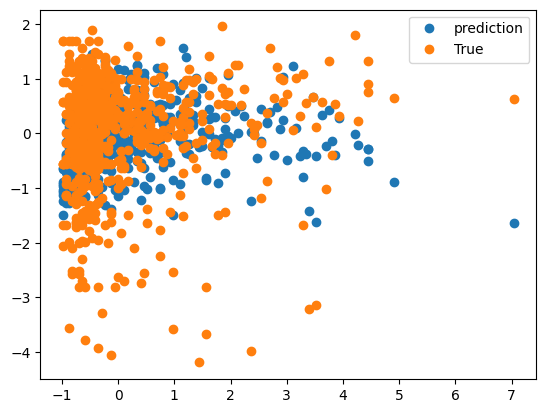

In [1013]:
fig, ax = plt.subplots()
#ax.plot(X_train["ABV"], y_train, "o", label="Data")
ax.plot(X_test["Alcohol"], ynewpred, "o", label="prediction")

ax.plot(X_test["Alcohol"], y_test, "o", label="True")
#ax.plot(np.hstack((X_train, X_test)), np.hstack((res.predict(X_train), ynewpred)), "r", label="OLS prediction")
ax.legend(loc="best")